# Implementation of Collaborative Filtering for Implicit Feedback Datasets
http://yifanhu.net/PUB/cf.pdf  
21.01.09 modified rank measure

In [1]:
import numpy as np
import data
from timeit import default_timer as timer

In [2]:
train = data.train
test = data.test

In [5]:
class MatrixFactorization():
    
    def __init__(self, train, test, f, epsilon):
        """
        param train : Rating Matrix for train
        param test : Rating Matrix for test
        param f : latent feature parameter
        """
        
        self._R = train # Implication Matrix for training size (m, n)
        self._R_test = test # Implication Matrix for test size (m, n)
        self._P = np.array(np.vectorize(lambda x: 0 if x==0 else 1)(train), dtype = np.float64) # Preference Matrix for training
        self._P_test = np.array(np.vectorize(lambda x: 0 if x==0 else 1)(test), dtype = np.float64) # Preference Matrix for training
        self._n_user_rated = np.sum(self._P, axis = 1)
        self._n_item_rated = np.sum(self._P, axis = 0)
        self._num_users, self._num_items = train.shape
        self._alpha = 40
        self._lambda = 0.002
        self._C = 1 + self._alpha * self._R # Confidence Matrix size (m, n)
        self._f = f
        self._epsilon = epsilon
        
        
    def fit(self):
        """
        training Matrix Factorization : update matrix latent weight and bias
        """
        # init latent features
        self._X = np.random.normal(scale = 1.0/self._f, size=(self._num_users, self._f))
        self._Y = np.random.normal(scale = 1.0/self._f, size=(self._num_items, self._f))
        
        count = 0
        cost_diff = 1000000
        self._training_process = []
        self._cost = [0]
        time = 0
        # repeat ALS until convergence
        while cost_diff > self._epsilon :
            
            start = timer()
            count += 1
            self._yTy = self._Y.T.dot(self._Y)
            for u in range(self._num_users):
                self.optimize_x(u)
            
            self._xTx = self._X.T.dot(self._X)
            for i in range(self._num_items):
                self.optimize_y(i)
            time += (timer() - start)
            
            cost = self.cost()
            self._cost.append(cost)
            if count > 1 :
                cost_diff = self._cost[count - 1] - self._cost[count]
            start_rank = timer()
            rank = self.compute_rank()
            print("time to compute rank : %.4f" % ( timer() - start_rank ))
            self._training_process.append([count, cost_diff, rank])
            print("count: %d, cost_difference : %.4f, rank : %.4f, time for a epoch : %.4f"% (count, cost_diff, rank, time))
            time = 0
                
                
    def optimize_x(self, u):
        """
        Optimize X given user u
        """
        C_u = np.diag(self._C[u, :]) # create diagonal matrix size (n, n)
        
        # (f,f) matrix
        temp1 = self._yTy + self._Y.T.dot(C_u - np.identity(self._num_items)).dot(self._Y) + self._lambda * np.identity(self._f)
        # (f,1) matrix
        temp2 = self._Y.T.dot(C_u).dot(self._P[u])
        
        self._X[u, :] = np.linalg.solve(temp1, temp2)
        
    
    def optimize_y(self, i):
        """
        Optimize X given user u
        """
        C_i = np.diag(self._C[:, i]) # create diagonal matrix size (m, m)
        
        # (f,f) matrix
        temp1 = self._xTx + self._X.T.dot(C_i - np.identity(self._num_users)).dot(self._X) + self._lambda * np.identity(self._f)
        # (f,1) matrix
        temp2 = self._X.T.dot(C_i).dot(self._P[:, i])
        
        self._Y[i, :] = np.linalg.solve(temp1, temp2)
        
                
    def cost(self):
        """
        compute Loss function
        """
        loss = np.sum(self._C * np.square(self._P - self._X.dot(self._Y.T))) + self._lambda * (np.linalg.norm(self._X) + np.linalg.norm(self._Y))
        
        return loss
    

    def compute_rank(self):
        
        prediction = self._X.dot(self._Y.T)
        temp_1 = 0
        temp_2 = 0
        
        for x in range(self._num_users) :
            inv_pre = -1 * prediction[x, :]
            sort_x = inv_pre.argsort() # index starts with 0
            sort_x = sort_x.argsort()
            rank_x = sort_x / len(sort_x)
            
            
            temp_1 += (self._R_test[x, :] * rank_x).sum()
            temp_2 += self._R_test[x, :].sum()
        
        rank = temp_1 / temp_2
            
        return rank
    
    
    def print_results(self):
        """
        print fit results
        """

        print("Final P hat matrix:")
        print(self._X.dot(self._Y.T))

In [6]:
np.random.seed(7)
    
np.seterr(all="warn")
    
factorizer = MatrixFactorization(train, test, f=40, epsilon = 100)
factorizer.fit()

time to compute rank : 0.2255
count: 1, cost_difference : 1000000.0000, rank : 0.2553, time for a epoch : 44.6225
time to compute rank : 0.2218
count: 2, cost_difference : 732013.3366, rank : 0.1351, time for a epoch : 45.3889
time to compute rank : 0.2267
count: 3, cost_difference : 48402.7589, rank : 0.1255, time for a epoch : 39.1366
time to compute rank : 0.2270
count: 4, cost_difference : 19222.9429, rank : 0.1227, time for a epoch : 41.4943
time to compute rank : 0.2498
count: 5, cost_difference : 10428.5123, rank : 0.1214, time for a epoch : 45.5812
time to compute rank : 0.2499
count: 6, cost_difference : 6535.5193, rank : 0.1207, time for a epoch : 44.4247
time to compute rank : 0.2294
count: 7, cost_difference : 4475.7953, rank : 0.1202, time for a epoch : 46.0584
time to compute rank : 0.2249
count: 8, cost_difference : 3262.9647, rank : 0.1200, time for a epoch : 44.0932
time to compute rank : 0.2463
count: 9, cost_difference : 2490.8589, rank : 0.1197, time for a epoch : 4

In [7]:
ind_list = []
drop_list = []
rank_list = []

for i in range(1, len(factorizer._training_process)):
    ind_list.append(factorizer._training_process[i][0])
    drop_list.append(factorizer._training_process[i][1])
    rank_list.append(factorizer._training_process[i][2])

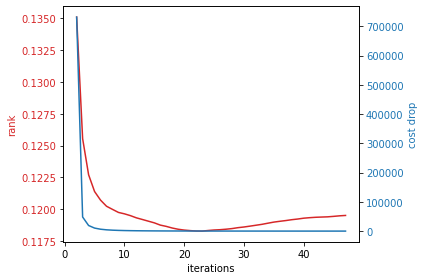

In [8]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('iterations')
ax1.set_ylabel('rank', color=color)
ax1.plot(ind_list, rank_list, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('cost drop', color=color)  # we already handled the x-label with ax1
ax2.plot(ind_list, drop_list, color=color)
ax2.tick_params(axis='y', labelcolor=color)


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()